In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

**Detecção de Incêndios Florestais utilizando CNN**

Informações sobre o Dataset:

Os dados foram retirados do kaggle: https://www.kaggle.com/datasets/phylake1337/fire-dataset
*   Os dados foram coletados para treinar um modelo para distinguir entre as imagens que contêm fogo (imagens de fogo) e imagens regulares (imagens que não são de fogo), então todo o problema é de classificação binária.
*   Os dados são divididos em 2 pastas, a pasta fireimages contém 755 imagens de fogo ao ar livre, algumas delas contêm fumaça, a outra não são imagens de fogo e contém 244 imagens da natureza (por exemplo: florestas, árvores, gramas, rios, pessoas, lagos, animais, estradas e cachoeiras).



In [ ]:
#Busca todos os arquivos PNG dentro de um diretório e seus subdiretórios.
dir_ = Path('./fot/')
png_filepaths = list(dir_.glob(r'**/*.png'))

In [ ]:
#Extrai os rótulos das imagens representadas pelos caminhos de arquivo na lista png_filepaths, considerando o nome do diretório pai de cada caminho como o rótulo.
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], png_filepaths))

In [ ]:
#Duas séries de dados são criadas: filepaths contendo os caminhos dos arquivos PNG e labels contendo os rótulos das imagens.
filepaths = pd.Series(png_filepaths, name='File', dtype=str)
labels = pd.Series(labels, name='Label', dtype=str)

#Concatena as séries filepaths e labels em um único DataFrame 
df = pd.concat([filepaths, labels], axis=1)

#Modifica os valores da coluna "Label" no DataFrame
df['Label'].replace({"non_fire_images": "non_fire", "fire_images": "fire"}, inplace=True)



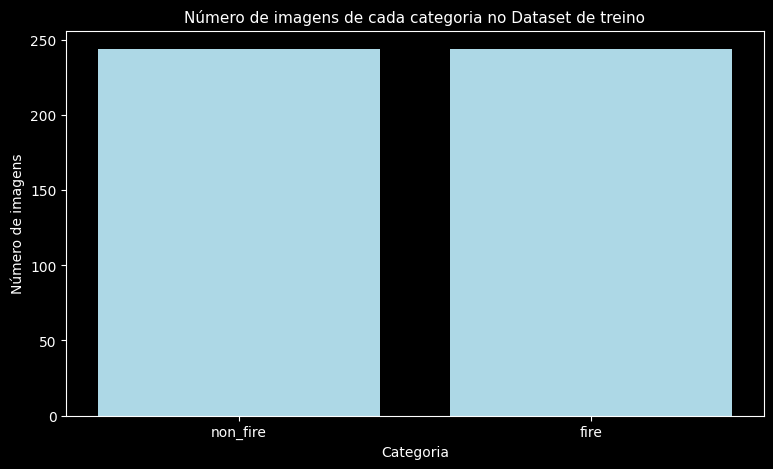

In [ ]:
# Visualizando os dados do dataset em um barplot usando matplotlib
vc = df['Label'].value_counts()
plt.figure(figsize=(9, 5))
plt.bar(vc.index, vc, color='lightblue')
plt.title("Número de imagens de cada categoria no Dataset de treino", fontsize=11)
plt.xlabel("Categoria")
plt.ylabel("Número de imagens")
plt.show()

In [ ]:
# Misturando o dataframe e resetando o index
df = df.sample(frac = 1, random_state = 83).reset_index(drop = True)

# Resultado
df.head()

,File,Label
0,fot/non_fire_images/non_fire.42.png,non_fire
1,fot/fire_images/fire.186.png,fire
2,fot/non_fire_images/non_fire.5.png,non_fire
3,fot/non_fire_images/non_fire.44.png,non_fire
4,fot/non_fire_images/non_fire.55.png,non_fire


**Dividindo em conjuntos de treinamento e teste**


*   Converte os dados em conjuntos de treinamento e teste.
*   90% treino 10% testes



In [ ]:
# Dividindo o dataframe em conjunto de treinamento e teste
train_df = df.sample(frac=0.9, random_state=86)
test_df = df.drop(train_df.index)

# Exibindo as primeiras linhas do conjunto de treinamento
display(train_df.head())

# Exibindo as primeiras linhas do conjunto de teste
test_df.head()

In [ ]:
# Visualizando os dados em ambos datasets
print('Dataset de treinamento:')

print(f'Número de imagens: {train_df.shape[0]}')

print(f'Número de imagens com fogo: {train_df["Label"].value_counts()[0]}')
print(f'Número de imagens sem fogo: {train_df["Label"].value_counts()[1]}\n')
      
print('Dataset de teste:')
      
print(f'Número de imagens no dataset de teste: {test_df.shape[0]}')
print(f'Número de imagens com fogo: {test_df["Label"].value_counts()[0]}')
print(f'Número de imagens sem fogo: {test_df["Label"].value_counts()[1]}')

Dataset de treinamento:
Número de imagens: 439
Número de imagens com fogo: 221
Número de imagens sem fogo: 218

Dataset de teste:
Número de imagens no dataset de teste: 49
Número de imagens com fogo: 26
Número de imagens sem fogo: 23


In [ ]:
# convertendo a Label para formato númerico para teste posteriormente
LE = LabelEncoder()

y_test = LE.fit_transform(test_df["Label"])

In [ ]:
# Separando os dados de treino
y_train = train_df["Label"]
x_train = train_df.drop(labels=["Label"], axis=1)
print(x_train.head())

                                    File
70   fot/non_fire_images/non_fire.70.png
3    fot/non_fire_images/non_fire.44.png
160         fot/fire_images/fire.128.png
315         fot/fire_images/fire.113.png
252          fot/fire_images/fire.79.png


In [ ]:
#Estilo de plotagem como "dark_background"
plt.style.use("dark_background")

Text(0.5, 1.0, 'fire')

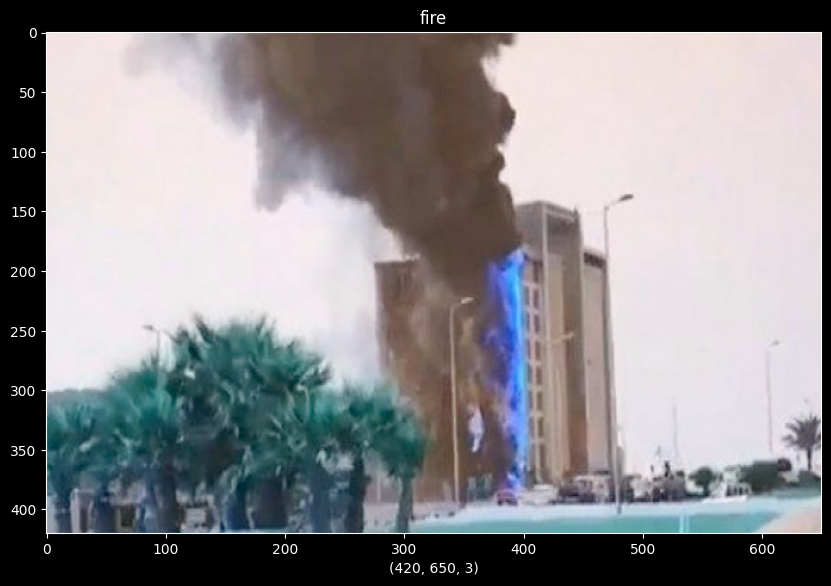

In [ ]:
# Observando a primeira imagem do dataset de treino (fire)
figure = plt.figure(figsize=(10, 10))
x = cv2.imread(train_df["File"][1])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(train_df["Label"][1])

Text(0.5, 1.0, 'non_fire')

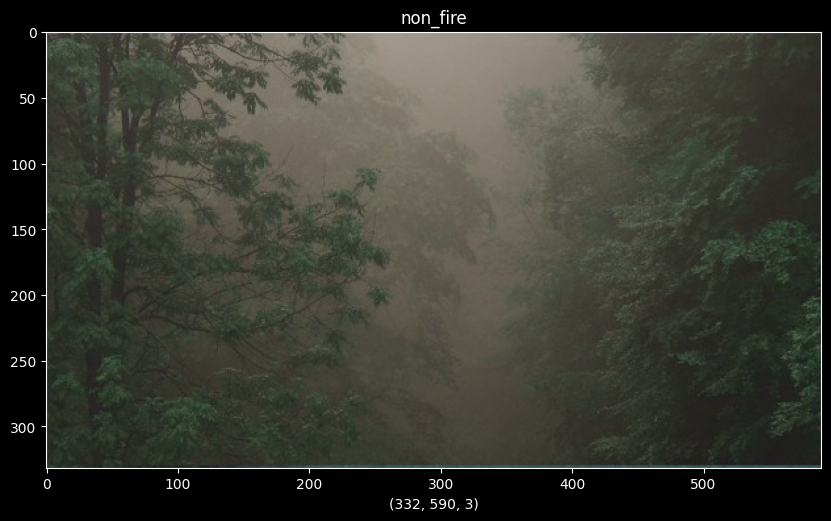

In [ ]:
# Observando as imagens do dataset de treino (nofire)
figure = plt.figure(figsize=(10,10))
x = cv2.imread(train_df["File"][2])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(train_df["Label"][2])

Text(0.5, 1.0, 'fire')

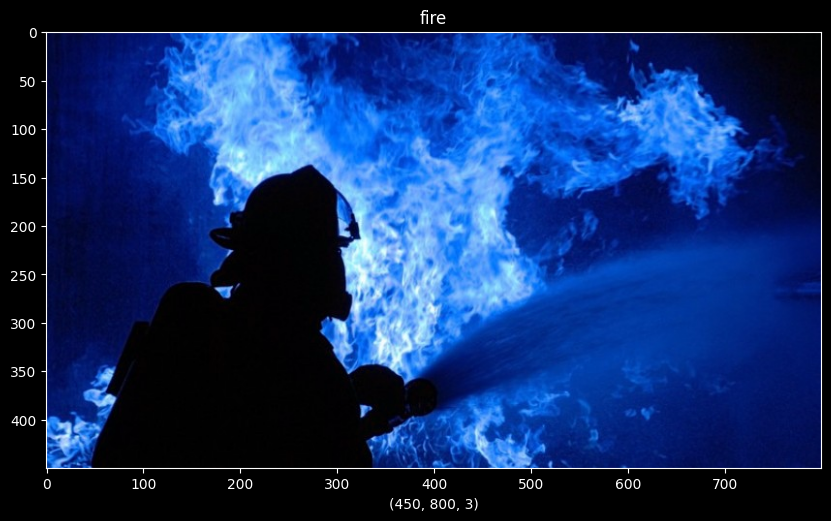

In [ ]:
# Observando a primeira imagem do dataset de teste (fire)
figure = plt.figure(figsize=(10, 10))
x = cv2.imread(test_df.iloc[0]["File"])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(test_df.iloc[0]["Label"])

Text(0.5, 1.0, 'fire')

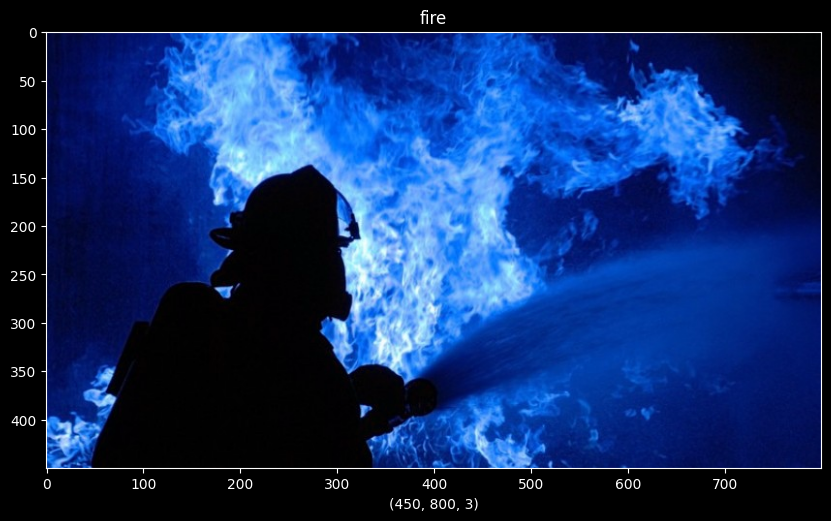

In [ ]:
# Observando a primeira imagem do dataset de teste (fire)
figure = plt.figure(figsize=(10, 10))
x = cv2.imread(test_df.iloc[0]["File"])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(test_df.iloc[0]["Label"])

**Pré-processamento das imagens** 

Pré-processamento das imagens da base de dados de treinamento usando o ImageDataGenerator, para a base de dados de teste foi realizada a normalização dos dados.


In [ ]:
#O train_datagen realiza uma série de transformações nas imagens de treinamento. O test_datagen apenas realiza o redimensionamento das imagens de teste.
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
#Divisão das bases de imagens para treinamento, validação e teste do modelo, para isso usamos o flow_from_dataframe.

print("Preparando o dataset de treino...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = "File",
    y_col = "Label",
    target_size = (250, 250),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 1,
    subset = "training")

print("Preparando o dataset de validação...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = "File",
    y_col = "Label",
    target_size = (250, 250),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 1,
    subset = "validation")

print("Preparando o dataset de teste...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "File",
    y_col = "Label",
    target_size = (250, 250),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 32)

print('Geradores de dados prontos!')

Preparando o dataset de treino...
Found 396 validated image filenames belonging to 2 classes.
Preparando o dataset de validação...
Found 43 validated image filenames belonging to 2 classes.
Preparando o dataset de teste...
Found 49 validated image filenames belonging to 2 classes.
Geradores de dados prontos!


**Construção do modelo**

CNNs são um tipo específico de rede neural artificial bastante eficaz para classificação de imagens. A construção de uma CNN começa com a especificação do tipo de modelo. Em nosso caso, foi utilizado um modelo Sequential.





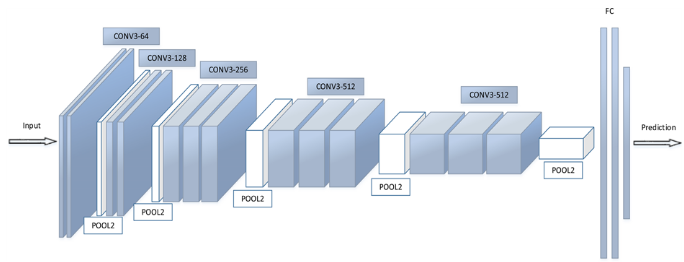

In [ ]:
CNN = Sequential()

CNN.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))

In [ ]:
CNN.add(MaxPooling2D(pool_size = (2, 2)))

In [ ]:
CNN.add(Conv2D(32, (3, 3), activation = 'relu'))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

In [ ]:
CNN.add(Conv2D(64, (3, 3), activation = 'relu'))
CNN.add(SpatialDropout2D(0.2))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

In [ ]:
CNN.add(Conv2D(128, (3, 3), activation = 'relu'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

In [ ]:
CNN.add(Flatten())

In [ ]:
# Camada de entrada
CNN.add(Dense(units = 256, activation = 'relu'))
CNN.add(Dropout(0.4))
# Camada de saida (classificação binária)
CNN.add(Dense(units = 1, activation = 'sigmoid'))
# Callbacks
callbacks = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 20, restore_best_weights = True)]

print(CNN.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 124, 124, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 122, 122, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 spatial_dropout2d_2 (Spatia  (None, 59, 59, 64)      

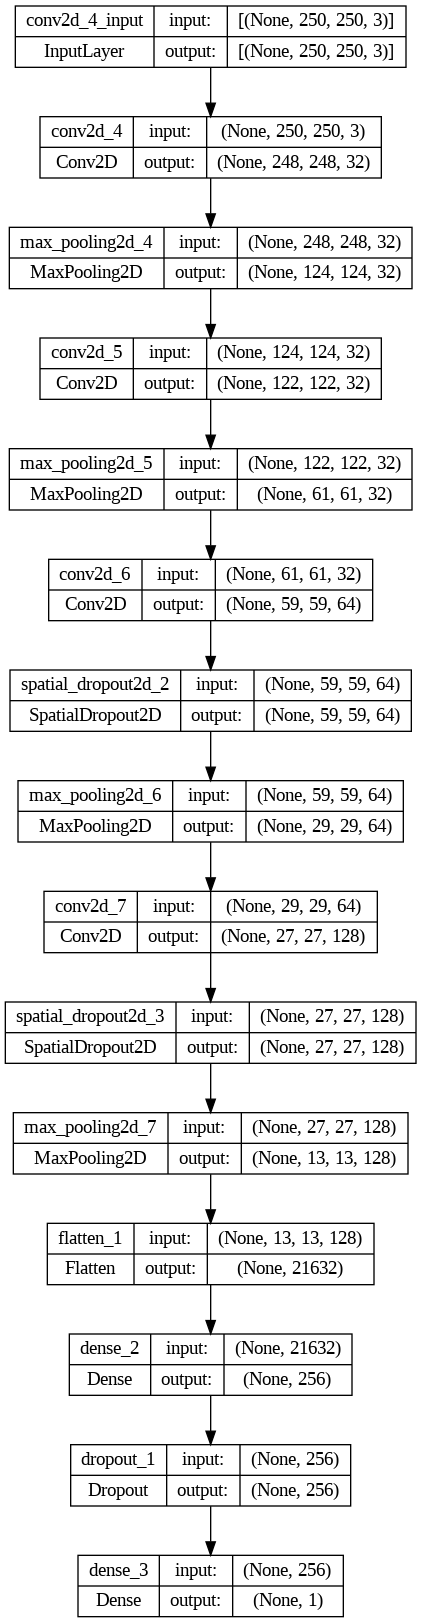

In [ ]:
plot_model(CNN, to_file='CNN_model.png', show_layer_names = True , show_shapes = True)

In [ ]:
# Compilação
CNN.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Inicio da contagem do tempo
start = dt.datetime.now()

# Treinamento
CNN_model = CNN.fit(training_set, epochs = 100, validation_data = validation_set, callbacks = callbacks)

# Fim da Contagem do tempo
end = dt.datetime.now()
time_CNN = end - start
print ('\nTempo de treinamento e validação: ', time_CNN)

Epoch 1/100
13/13 [==============================] - 45s 3s/step - loss: 0.5664 - accuracy: 0.6995 - val_loss: 0.3701 - val_accuracy: 0.8140
Epoch 2/100
13/13 [==============================] - 43s 3s/step - loss: 0.2935 - accuracy: 0.8636 - val_loss: 0.1676 - val_accuracy: 0.9302
Epoch 3/100
13/13 [==============================] - 42s 3s/step - loss: 0.2931 - accuracy: 0.9167 - val_loss: 0.4146 - val_accuracy: 0.8140
Epoch 4/100
13/13 [==============================] - 42s 3s/step - loss: 0.2798 - accuracy: 0.8737 - val_loss: 0.1602 - val_accuracy: 0.9302
Epoch 5/100
13/13 [==============================] - 44s 3s/step - loss: 0.2218 - accuracy: 0.9217 - val_loss: 0.1633 - val_accuracy: 0.9535
Epoch 6/100
13/13 [==============================] - 42s 3s/step - loss: 0.1641 - accuracy: 0.9318 - val_loss: 0.1937 - val_accuracy: 0.9535
Epoch 7/100
13/13 [==============================] - 40s 3s/step - loss: 0.2387 - accuracy: 0.9242 - val_loss: 0.1493 - val_accuracy: 0.9302
Epoch 8/100
1

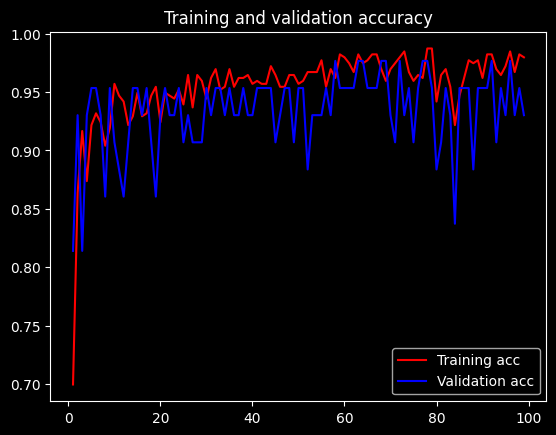

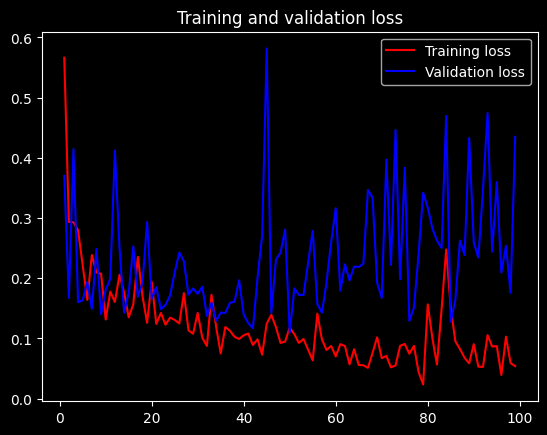

In [ ]:
#São plotados os gráficos de precisão (accuracy) e perda (loss) durante o treinamento e a validação da CNN.
acc = CNN_model.history['accuracy']
val_acc = CNN_model.history['val_accuracy']
loss = CNN_model.history['loss']
val_loss = CNN_model.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
#Visualizando resultados e gerando previsões.
score = CNN.evaluate(test_set)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

2/2 [==============================] - 3s 388ms/step - loss: 0.3876 - accuracy: 0.9388
Test Loss: 0.3876267969608307
Test Accuracy: 0.9387755393981934


In [ ]:
y_pred = CNN.predict(test_set)
y_pred = np.round(y_pred)

2/2 [==============================] - 2s 313ms/step


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.88      0.94        26
           1       0.88      1.00      0.94        23

    accuracy                           0.94        49
   macro avg       0.94      0.94      0.94        49
weighted avg       0.95      0.94      0.94        49



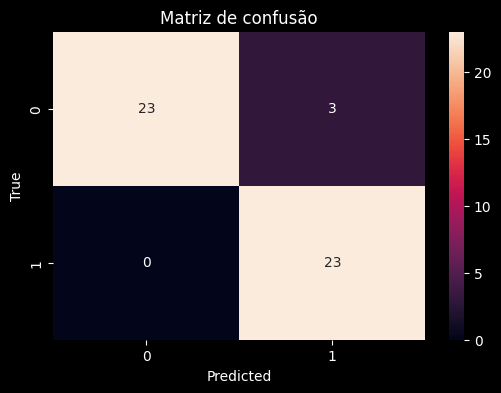

In [ ]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
plt.title("Matriz de confusão")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()